In [1]:
import pandas as pd
import numpy as np

import sidetable as stb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats

plt.rcParams['figure.figsize'] = (10, 10)
pd.options.display.max_columns = None

from datetime import datetime

In [2]:
df = pd.read_csv("data/bikes.csv", index_col= 0)
df.drop(["instant"], axis= 1, inplace= True)

In [3]:
df.shape

(730, 15)

In [4]:
df.stb.missing()

,missing,total,percent
dteday,0,730,0.0
season,0,730,0.0
yr,0,730,0.0
mnth,0,730,0.0
holiday,0,730,0.0
weekday,0,730,0.0
workingday,0,730,0.0
weathersit,0,730,0.0
temp,0,730,0.0
atemp,0,730,0.0


In [5]:
df.dtypes

dteday         object
season         object
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
df[df["season"] == "summer"]
df.sample()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
716,18-12-2019,winter,1,12,0,2,1,1,16.844153,20.4854,66.625,14.834068,433,5124,5557


# CAMBIO NOMBRE COLUMNAS:

In [3]:
diccionario = {
    "dteday": "fecha",
    "season": "estacion",
    "yr": "año",
    "mnth": "mes", 
    "holiday": "festivo", 
    "weekday": "dia_sem",
    "workingday": "laborable", 
    "weathersit": "prevision_tiempo",
    "temp": "temperatura",
    "atemp": "sensacion_termica", 
    "hum": "humedad", 
    "windspeed": "velocidad_viento", 
    "casual": "clientes_casual", 
    "registered": "clientes_registrados", 
    "cnt":"total_bicis"}

In [4]:
df.rename(columns = diccionario, inplace =True)
df.head()

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,clientes_casual,clientes_registrados,total_bicis
0,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# CAMBIO DATOS ESTACIÓN:

In [5]:
#Convertimos la columna fecha a formato datetime

df["fecha"] = df["fecha"].astype("datetime64", errors ="ignore")


In [7]:
#indicamos que el formato datetime sea el mismo que ya tiene la columna

df['fecha']= pd.to_datetime(df['fecha'], format = "%d-%m-%Y")

In [9]:
#Creamos la función para cambiar las estaciones del año

def cambio_estacion(fecha):
    inicio_primavera = datetime(fecha.year, 3, 20)
    fin_primavera = datetime(fecha.year, 6, 20)
    inicio_verano = datetime(fecha.year, 6, 21)
    fin_verano = datetime(fecha.year, 9, 22)
    inicio_otoño = datetime(fecha.year, 9, 23)
    fin_otoño = datetime(fecha.year, 12, 20)
    # Comprueba en qué estación del año cae la fecha dada
    if inicio_primavera <= fecha <= fin_primavera:
        return "Primavera"
    elif inicio_verano <= fecha <= fin_verano:
        return "Verano"
    elif inicio_otoño <= fecha <= fin_otoño:
        return "Otoño"
    else:
        return "Invierno"

In [10]:
df['estacion'] = df['fecha'].apply(cambio_estacion)

In [13]:
df['estacion'].unique()

array(['Invierno', 'Primavera', 'Verano', 'Otoño'], dtype=object)

In [12]:
df.sample(5)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,clientes_casual,clientes_registrados,total_bicis
392,2019-01-28,Invierno,1,1,0,6,0,1,12.949153,16.31895,54.3333,14.125543,775,3248,4023
691,2019-11-23,Otoño,1,11,0,5,1,1,15.101653,18.93895,56.8750,9.917407,1603,2307,3910
63,2018-05-03,Primavera,0,3,0,6,0,2,15.750847,18.93895,78.9167,16.875357,640,1437,2077
465,2019-11-04,Otoño,1,4,0,3,1,1,14.296536,16.86370,46.9565,19.783358,482,4380,4862
555,2019-10-07,Otoño,1,7,0,2,1,2,29.554153,33.23980,66.7500,10.166379,954,5336,6290


In [14]:
#Comprobamos si total_bicis es la suma de clientes_casual y clientes_registrados

df['suma_clientes'] = df['clientes_casual'] + df['clientes_registrados']

In [18]:
df.sample(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,clientes_casual,clientes_registrados,total_bicis,suma_clientes
30,2018-01-31,Invierno,0,1,0,1,1,2,7.414153,9.3125,60.3750,12.541864,42,1459,1501,1501
684,2019-11-16,Otoño,1,11,0,5,1,1,14.145000,17.3602,52.4583,11.458675,484,5214,5698,5698


CONCLUSION

La columna total_bicis es la suma de las columnas clientes_casual + clientes_registrados, por tanto confirmamos en las columnas clientes_casual y clientes_registrados, si un cliente ha alquilado varias veces en un día, se contabiliza todas esas veces. 

In [21]:
#Eliminamos la columna de la suma, ya que no la vamos a necesitar más

df.drop(['suma_clientes'], axis = 1, inplace = True)

In [23]:
#Cambiamos los nombres de las columnas para que se entienda mejor
diccionario2 = {
    "clientes_casual": "alquiler_casual",
    "clientes_registrados": "alquiler_registrado",
    "total_bicis": "total_alquileres"}

df.rename(columns = diccionario2, inplace =True)
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,temperatura,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2018-02-01,Invierno,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [24]:
df.dtypes

fecha                  datetime64[ns]
estacion                       object
año                             int64
mes                             int64
festivo                         int64
dia_sem                         int64
laborable                       int64
prevision_tiempo                int64
temperatura                   float64
sensacion_termica             float64
humedad                       float64
velocidad_viento              float64
alquiler_casual                 int64
alquiler_registrado             int64
total_alquileres                int64
dtype: object

In [40]:
#Hacemos dos listas con variables numéricas y variables categóricas

lista_num = ['temperatura', 'sensacion_termica', 'humedad', 'velocidad_viento', 'alquiler_casual', 'alquiler_registrado', 'total_alquileres']
lista_cat = ['estacion', 'año', 'mes', 'festivo', 'dia_sem', 'laborable', 'prevision_tiempo']
lista_cat2 = ['año', 'mes', 'festivo', 'dia_sem', 'laborable', 'prevision_tiempo']

In [32]:
dict(enumerate(lista_num))

{0: 'temperatura',
 1: 'sensacion_termica',
 2: 'humedad',
 3: 'velocidad_viento',
 4: 'alquiler_casual',
 5: 'alquiler_registrado',
 6: 'total_alquileres'}

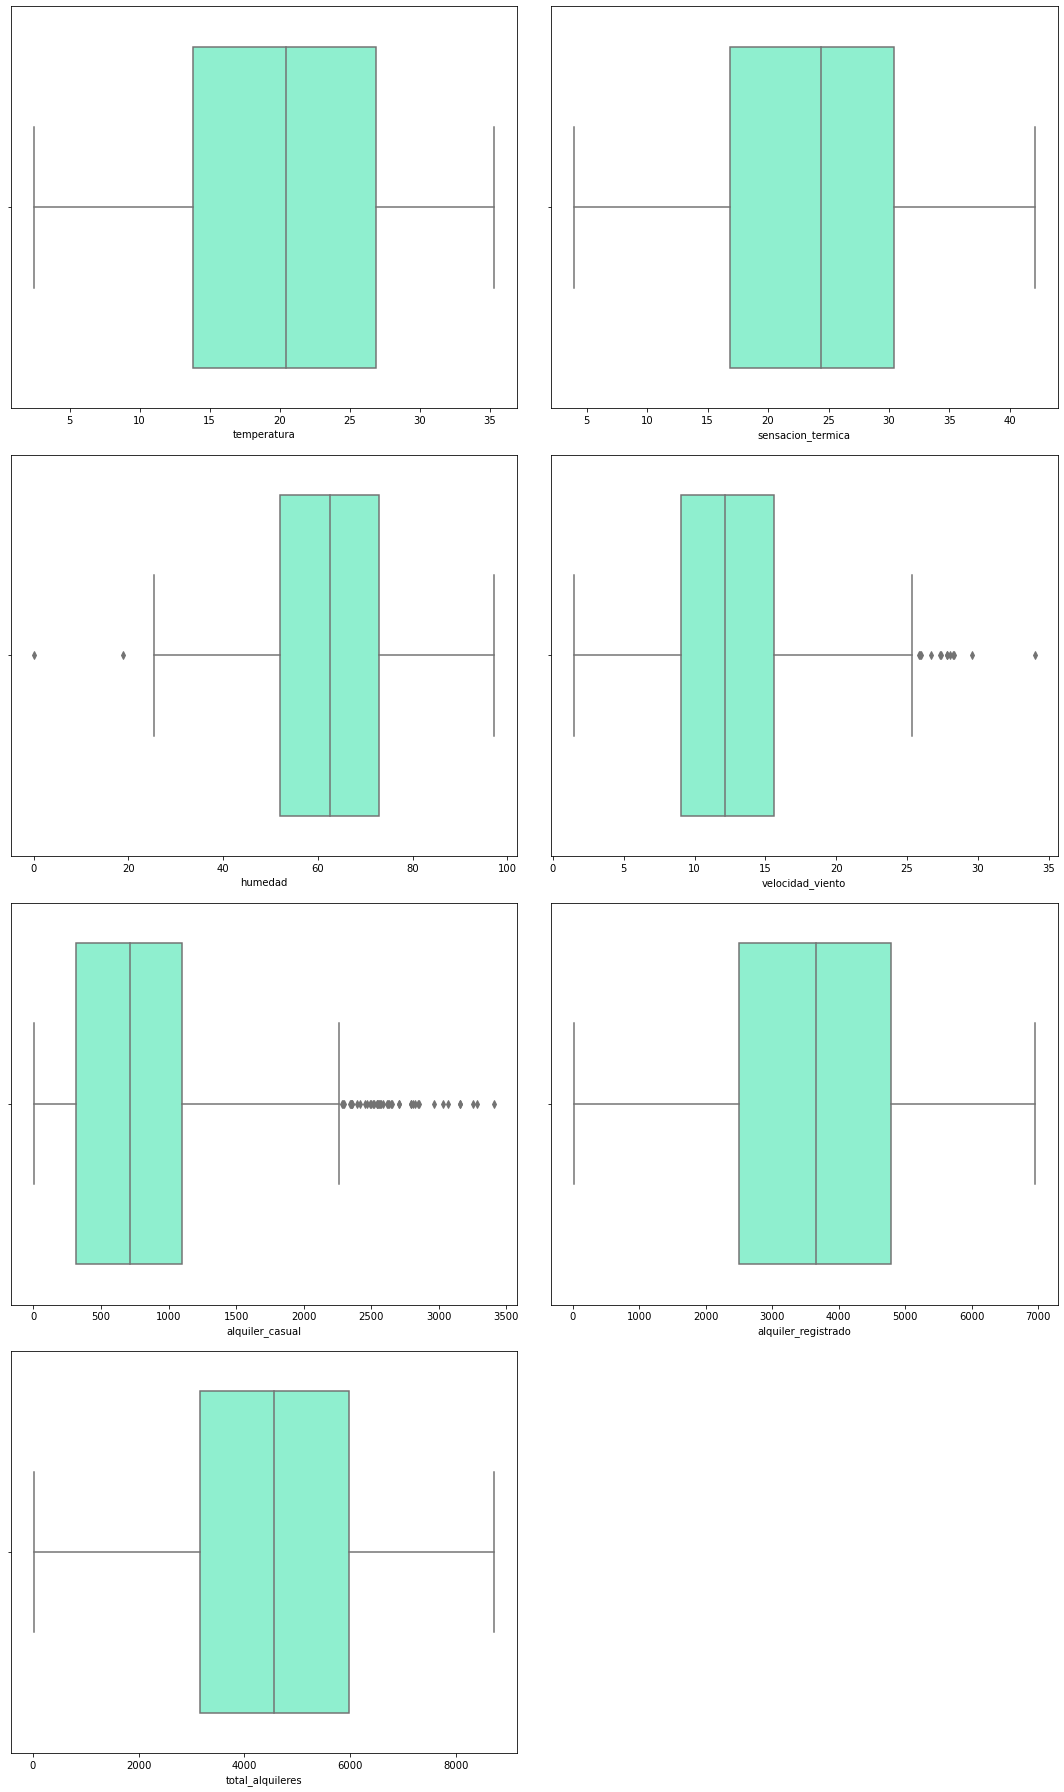

In [35]:
#Realizamos los boxplot de las variables numéricas

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat

for indice, elemento in enumerate(lista_num):
    sns.boxplot(x = elemento, data = df, ax=axes[indice], color = "aquamarine")
    
    
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show();

CONCLUSIONES

Estas son las columnas que presentan outliers:

    -humedad
    -velocidad_viento
    -alquiler_casual

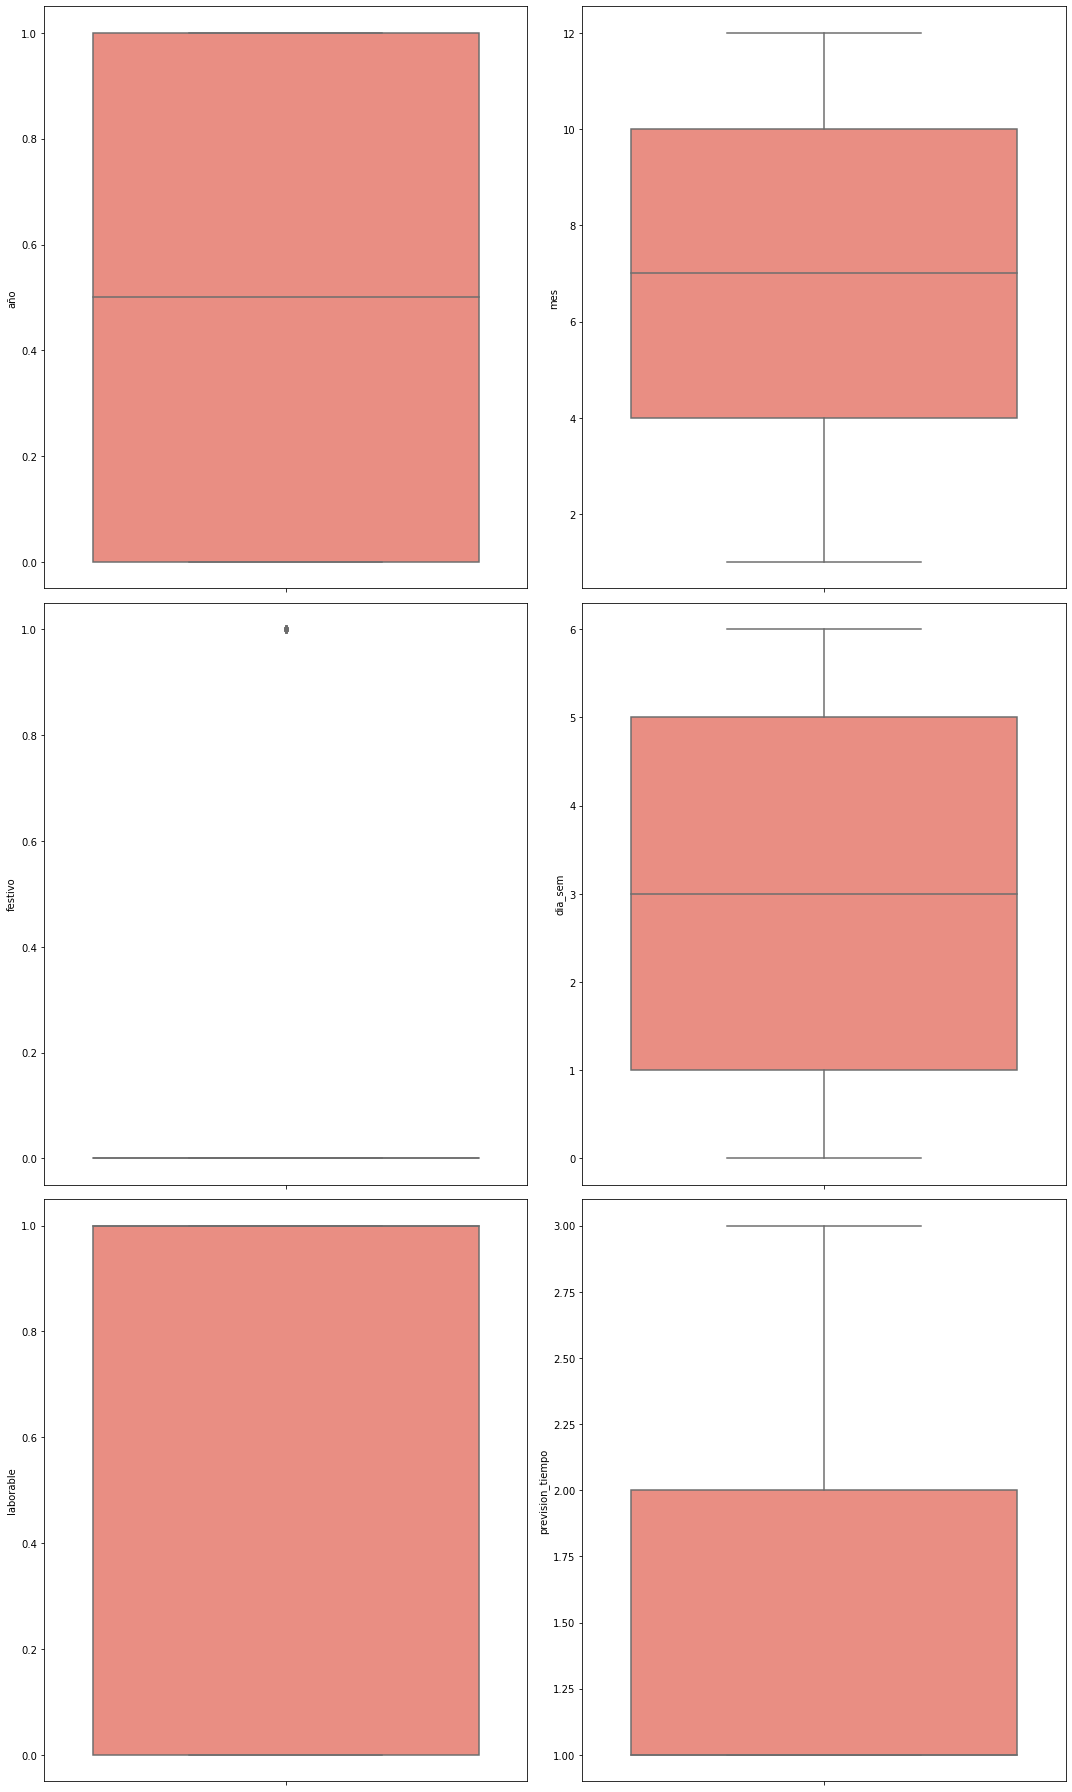

In [46]:
#Realizamos los boxplot de las variables categoricas

fig, axes = plt.subplots(3, 2, figsize=(15, 25))
axes = axes.flat

for indice, elemento in enumerate(lista_cat2):
    sns.boxplot(y = elemento, data = df, ax=axes[indice], color = "salmon")
    
    
plt.tight_layout()
plt.show()

In [45]:
df['festivo'].value_counts()

0    709
1     21
Name: festivo, dtype: int64

CONCLUSION

Hay outliers en la columna de festivos, ya que hay bastante más días que no son festivos (0) que días que son festivos (1)